In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


# Read in data

In [3]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./metadata.csv") # read in csv

mdata.head() # head data to check

,file,species,px_cm,base_x,base_y,tip_x,tip_y
0,LBATSPA21166-2x4-F-MI_0_c_1_9.tif,batsonii,118,522,978,537.5,121.5
1,LBATSPA21166-2x4-F-MI_0_c_2_9.tif,batsonii,118,512,966,541.5,137.5
2,LBATSPA21166-2x4-F-MI_0_c_3_9.tif,batsonii,118,560,1036,577.5,63.5
3,LBATSPA21166-2x4-F-MI_0_c_4_9.tif,batsonii,118,522,1068,573.5,27.5
4,LBATSPA21166-2x4-F-MI_0_c_5_9.tif,batsonii,118,534,1060,523.5,41.5


In [4]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./binary_leaves/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

#file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['LBATSPA21166-2x4-F-MI_0_c_1_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_2_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_3_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_4_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_5_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_6_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_7_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_8_9.tif',
 'LBATSPA21166-2x4-F-MI_0_c_9_9.tif',
 'LBATSPA21166-2x4-F-MI_0_r_10_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_11_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_12_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_13_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_14_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_15_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_1_15.TIF',
 'LBATSPA21166-2x4-F-MI_0_r_2_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_3_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_4_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_5_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_6_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_7_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_8_15.tif',
 'LBATSPA21166-2x4-F-MI_0_r_9_15.tif',
 'LBATSPA21166-4x2-H-MI_0_c_1_8.tif',
 'LBATSPA21166-4x2-H-MI_0_c_2

# Process and landmark data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

In [5]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################
#################

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf] # select the current image
    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(np.array(sorted_x_conts[0], dtype=np.float32), 
                                           np.array(sorted_y_conts[0], dtype=np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = mdata["px_cm"][lf]

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[lf,:,:] = cm_lf

0 LBATSPA21166-2x4-F-MI_0_c_1_9.tif
1 LBATSPA21166-2x4-F-MI_0_c_2_9.tif
2 LBATSPA21166-2x4-F-MI_0_c_3_9.tif
3 LBATSPA21166-2x4-F-MI_0_c_4_9.tif
4 LBATSPA21166-2x4-F-MI_0_c_5_9.tif
5 LBATSPA21166-2x4-F-MI_0_c_6_9.tif
6 LBATSPA21166-2x4-F-MI_0_c_7_9.tif
7 LBATSPA21166-2x4-F-MI_0_c_8_9.tif
8 LBATSPA21166-2x4-F-MI_0_c_9_9.tif
9 LBATSPA21166-2x4-F-MI_0_r_1_15.TIF
10 LBATSPA21166-2x4-F-MI_0_r_10_15.tif
11 LBATSPA21166-2x4-F-MI_0_r_11_15.tif
12 LBATSPA21166-2x4-F-MI_0_r_12_15.tif
13 LBATSPA21166-2x4-F-MI_0_r_13_15.tif
14 LBATSPA21166-2x4-F-MI_0_r_14_15.tif
15 LBATSPA21166-2x4-F-MI_0_r_15_15.tif
16 LBATSPA21166-2x4-F-MI_0_r_2_15.tif
17 LBATSPA21166-2x4-F-MI_0_r_3_15.tif
18 LBATSPA21166-2x4-F-MI_0_r_4_15.tif
19 LBATSPA21166-2x4-F-MI_0_r_5_15.tif
20 LBATSPA21166-2x4-F-MI_0_r_6_15.tif
21 LBATSPA21166-2x4-F-MI_0_r_7_15.tif
22 LBATSPA21166-2x4-F-MI_0_r_8_15.tif
23 LBATSPA21166-2x4-F-MI_0_r_9_15.tif
24 LBATSPA21166-4x2-H-MI_0_c_1_8.tif
25 LBATSPA21166-4x2-H-MI_0_c_2_8.tif
26 LBATSPA21166-4x2-H-MI_0_

246 LFLACLD17116-L-MI_2_r_13_19.tif
247 LFLACLD17116-L-MI_2_r_14_19.tif
248 LFLACLD17116-L-MI_2_r_15_19.tif
249 LFLACLD17116-L-MI_2_r_16_19.tif
250 LFLACLD17116-L-MI_2_r_17_19.tif
251 LFLACLD17116-L-MI_2_r_18_19.tif
252 LFLACLD17116-L-MI_2_r_19_19.tif
253 LFLACLD17116-L-MI_2_r_2_19.tif
254 LFLACLD17116-L-MI_2_r_3_19.tif
255 LFLACLD17116-L-MI_2_r_4_19.tif
256 LFLACLD17116-L-MI_2_r_5_19.tif
257 LFLACLD17116-L-MI_2_r_6_19.tif
258 LFLACLD17116-L-MI_2_r_7_19.tif
259 LFLACLD17116-L-MI_2_r_8_19.tif
260 LFLACLD17116-L-MI_2_r_9_19.tif
261 LGEORMJ21173-1x2_0_c_10_17.tif
262 LGEORMJ21173-1x2_0_c_11_17.tif
263 LGEORMJ21173-1x2_0_c_12_17.tif
264 LGEORMJ21173-1x2_0_c_13_17.tif
265 LGEORMJ21173-1x2_0_c_14_17.tif
266 LGEORMJ21173-1x2_0_c_15_17.tif
267 LGEORMJ21173-1x2_0_c_16_17.tif
268 LGEORMJ21173-1x2_0_c_17_17.tif
269 LGEORMJ21173-1x2_0_c_4_17.tif
270 LGEORMJ21173-1x2_0_c_5_17.tif
271 LGEORMJ21173-1x2_0_c_6_17.tif
272 LGEORMJ21173-1x2_0_c_7_17.tif
273 LGEORMJ21173-1x2_0_c_8_17.tif
274 LGEORMJ21173-1

501 LPUBEAC14502_0_c_13_14.tif
502 LPUBEAC14502_0_c_14_14.tif
503 LPUBEAC14502_0_c_2_14.tif
504 LPUBEAC14502_0_c_3_14.tif
505 LPUBEAC14502_0_c_4_14.tif
506 LPUBEAC14502_0_c_5_14.tif
507 LPUBEAC14502_0_c_6_14.tif
508 LPUBEAC14502_0_c_7_14.tif
509 LPUBEAC14502_0_c_8_14.tif
510 LPUBEAC14502_0_c_9_14.tif
511 LPUBEAC14502_0_r_1_14.tif
512 LPUBEAC14502_0_r_10_14.tif
513 LPUBEAC14502_0_r_11_14.tif
514 LPUBEAC14502_0_r_12_14.tif
515 LPUBEAC14502_0_r_13_14.tif
516 LPUBEAC14502_0_r_14_14.tif
517 LPUBEAC14502_0_r_2_14.tif
518 LPUBEAC14502_0_r_3_14.tif
519 LPUBEAC14502_0_r_4_14.tif
520 LPUBEAC14502_0_r_5_14.tif
521 LPUBEAC14502_0_r_6_14.tif
522 LPUBEAC14502_0_r_7_14.tif
523 LPUBEAC14502_0_r_8_14.tif
524 LPUBEAC14502_0_r_9_14.tif
525 LPUBENC12501-F-MI_0_c_1_10.tif
526 LPUBENC12501-F-MI_0_c_10_10.tif
527 LPUBENC12501-F-MI_0_c_2_10.tif
528 LPUBENC12501-F-MI_0_c_3_10.tif
529 LPUBENC12501-F-MI_0_c_4_10.tif
530 LPUBENC12501-F-MI_0_c_5_10.tif
531 LPUBENC12501-F-MI_0_c_6_10.tif
532 LPUBENC12501-F-MI_0_c_7

# Check by plotting random leaves

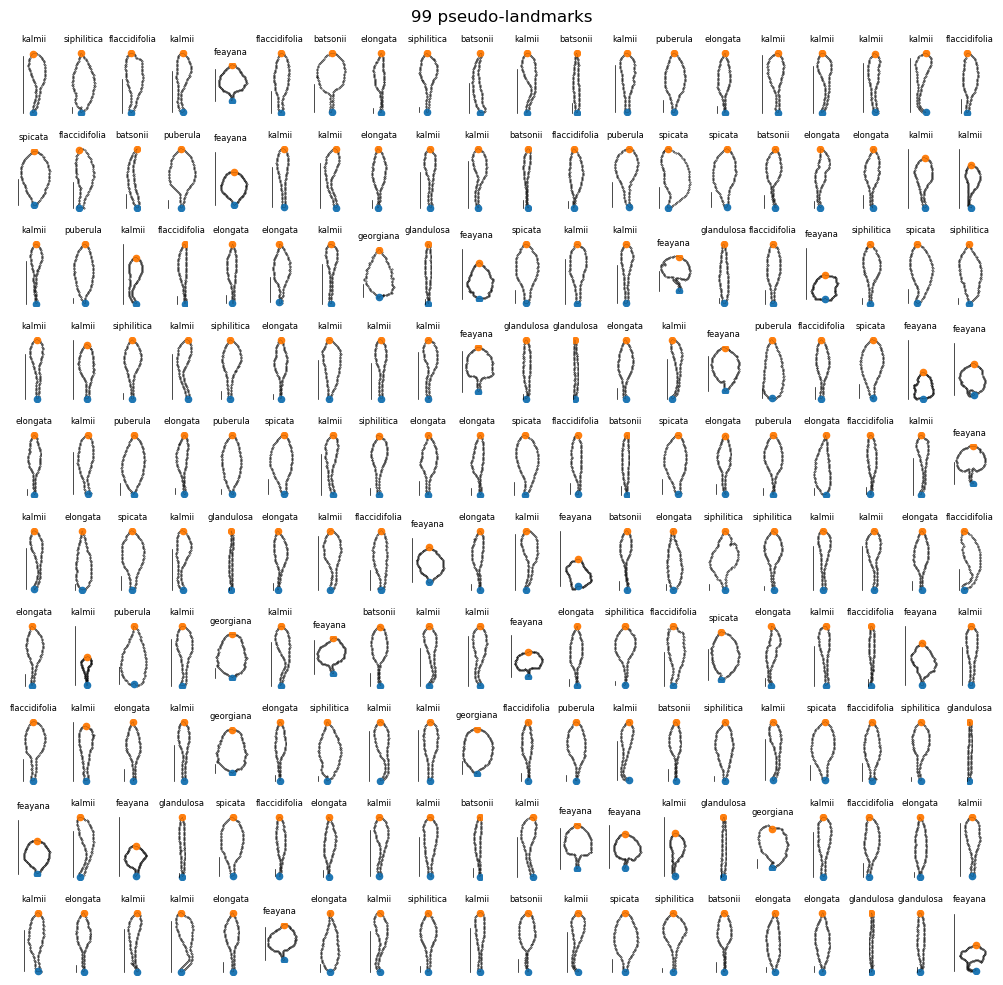

In [6]:
# Plot random leaves and check that it is working

plt.figure(figsize=(10,10)) # set figure size

rand_indices = np.random.randint(0,len(cm_arr),200) # generate random indices of leaves

plot_num = 1 # plot counter number

for i in rand_indices:
    
    plt.subplot(10,20,plot_num) # subplot number
    
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=0.1) # outline
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=0.1) # points
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1], s=20) # base
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1], s=20) # tip
    
    plt.title(mdata["species"][i], fontsize=6)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    plot_num += 1
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area
- `asymmetry`: the Procrustes distance between the superimposed left and right sides of a leaf outline. Lower values are more symmetric. Higher values are more asymmetric.  

Data is stored in the `mdata` dataframe.

In [7]:
# lists to store variables
width_list = []
length_list = []
area_list = []
solidity_list = []
asymmetry_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    ##########################
    ### CALCULATE SYMMETRY ###
    ##########################
    
    left_side = curr_lf[:(res-1)+1,] # isolate left side of leaf
    right_side = curr_lf[(res-1):,] # isolate right side of leaf
    right_side = right_side[::-1] # reverse the right side to align indices with left

    # calculate procrustes distance between left and right side of leaf
    s1, s2, distance = procrustes(left_side, right_side) 
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    solidity_list.append(solidity)
    asymmetry_list.append(distance)
    
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["solidity"] = solidity_list
mdata["asymmetry"] = asymmetry_list
    

#### Retrieve information from the file name and store in dataframe

In [8]:
# expand file name delimiting by underscore
file_info = mdata["file"].str.split("_", expand=True)

# assign new
file_info.columns=["id","plant_num","rose_caul","node","count"]

# remove the ".tif"
file_info["count"] = file_info["count"].str[0:-4]

# convert strings into integers
file_info["node"] = file_info["node"].astype(int)
file_info["count"] = file_info["count"].astype(int)

# create relative node, which is node/count
file_info["rel_node"] = file_info["node"]/file_info["count"]

# combine file info with the metadata into one dataframe
mdata = pd.concat([file_info.reset_index(drop=True),mdata.reset_index(drop=True)], axis=1)

# Pair plots by species

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


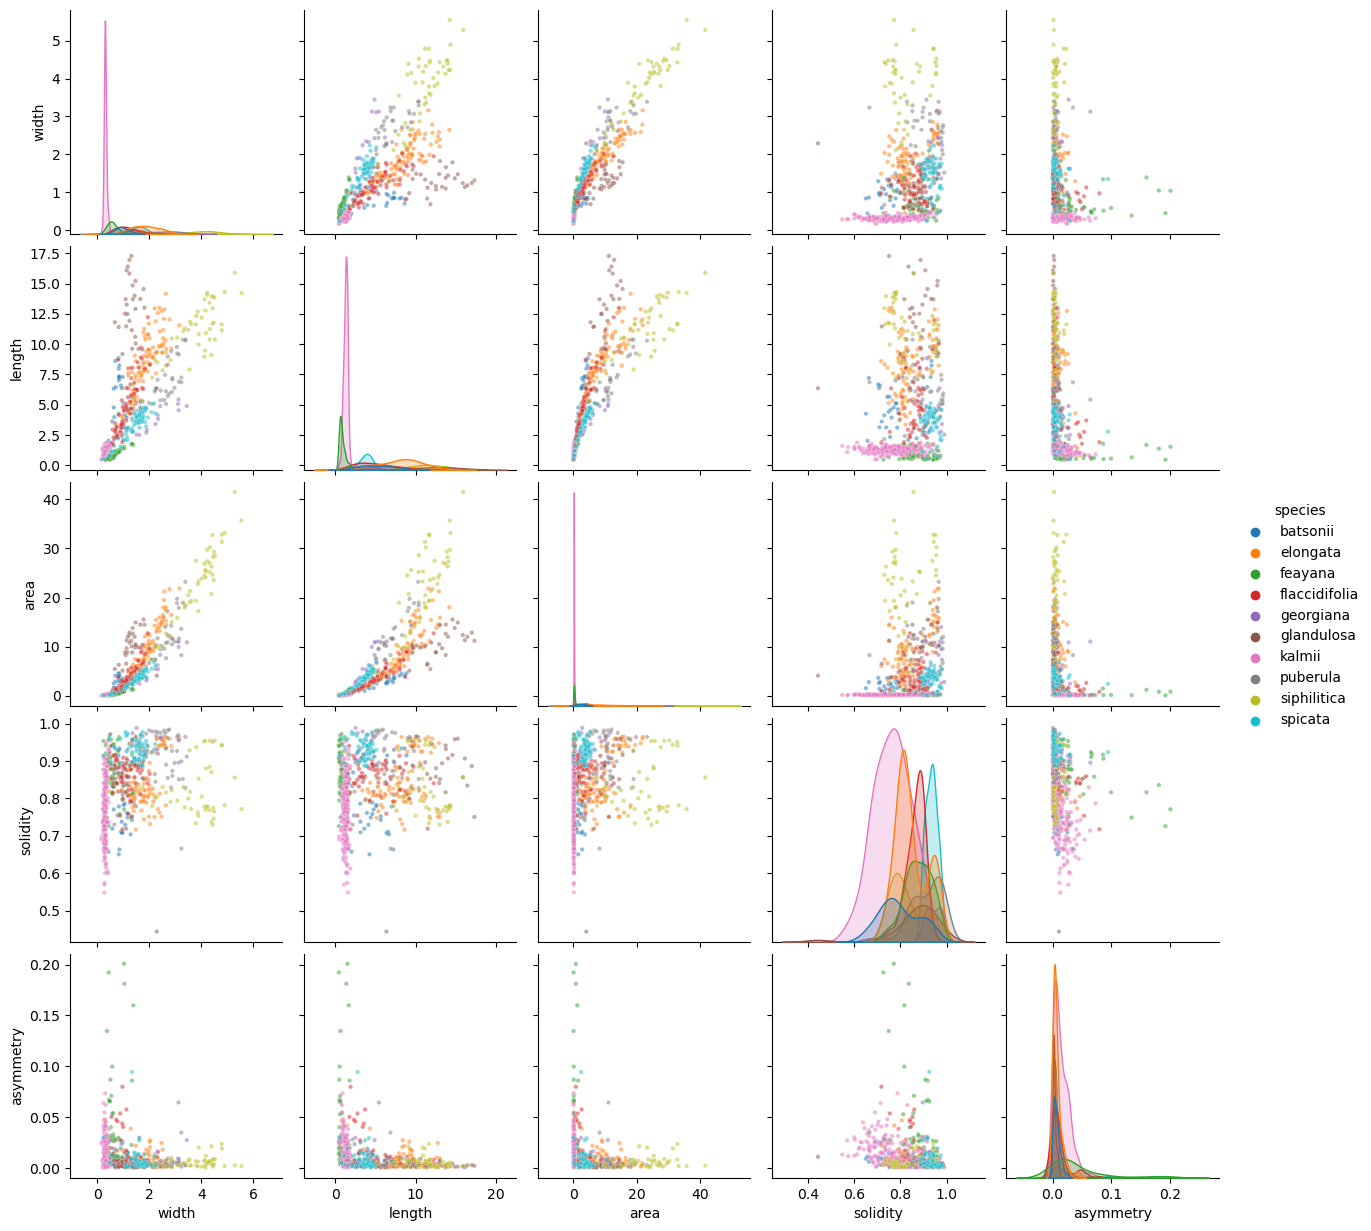

In [9]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","asymmetry"],
             y_vars=["width", "length", "area","solidity","asymmetry"],
             hue="species",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


# Pair plots by rosette/cauline

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


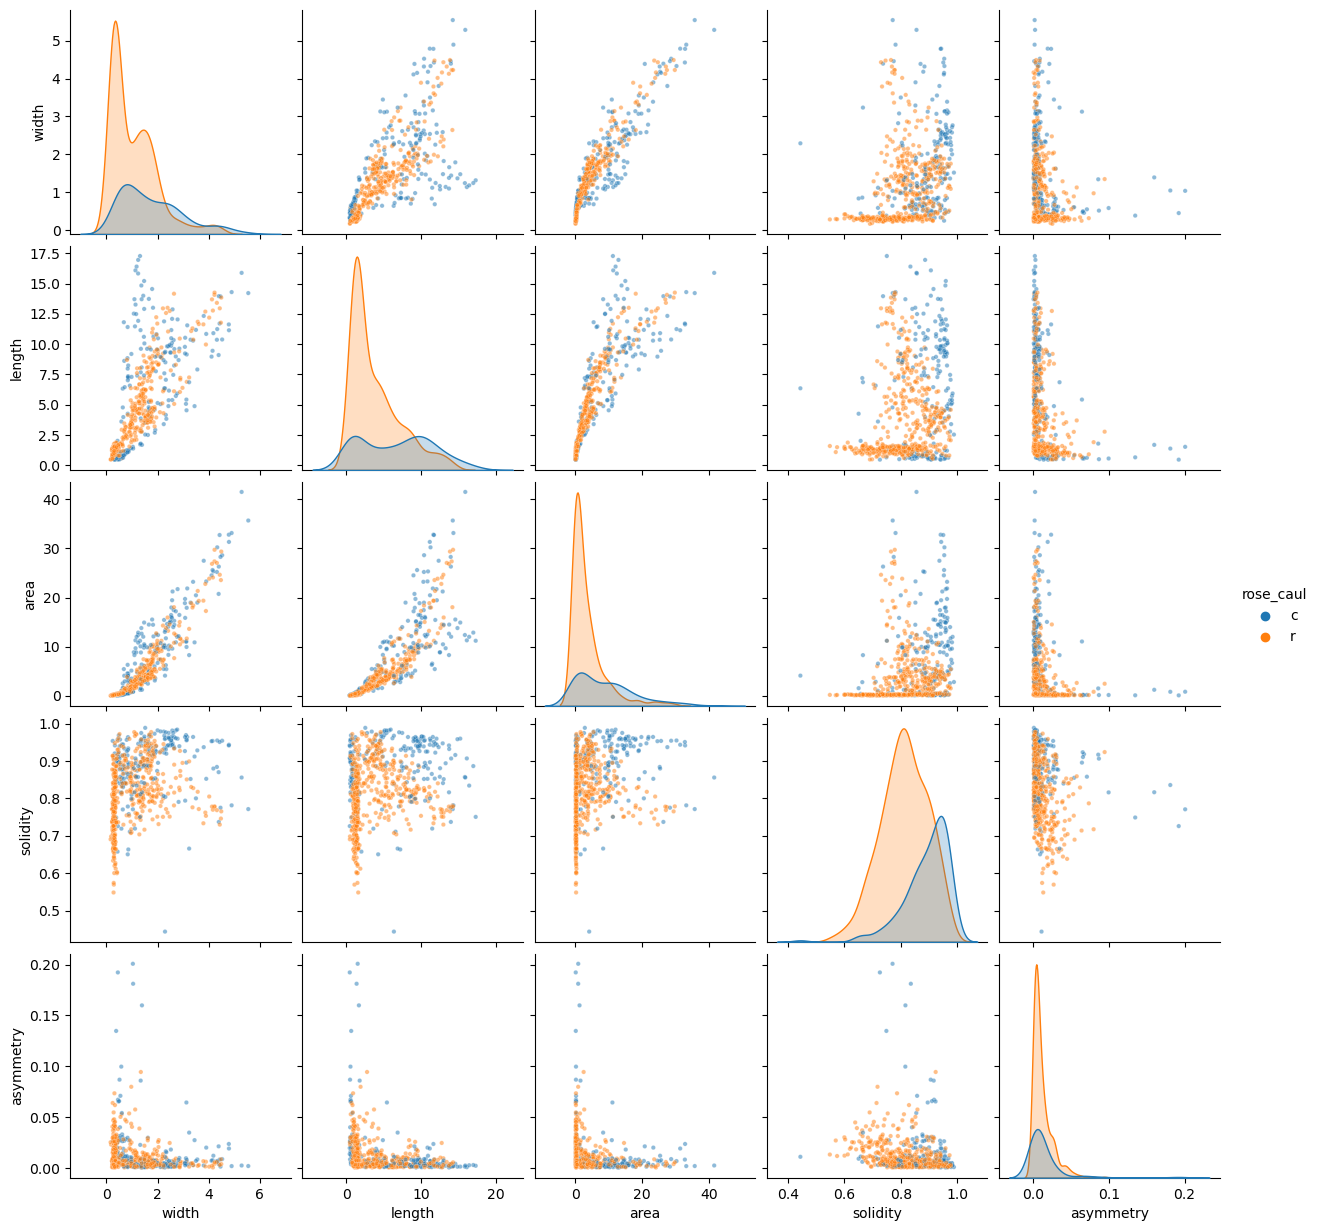

In [10]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","asymmetry"],
             y_vars=["width", "length", "area","solidity","asymmetry"],
             hue="rose_caul",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )

# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [11]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

In [12]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 68.3%, 68.3%
PC2: 9.8%, 78.2%
PC3: 7.4%, 85.5%
PC4: 3.4%, 88.9%
PC5: 2.9%, 91.8%
PC6: 2.1%, 94.0%
PC7: 1.1%, 95.1%
PC8: 1.0%, 96.1%
PC9: 0.8%, 96.8%
PC10: 0.5%, 97.4%
PC11: 0.4%, 97.7%
PC12: 0.3%, 98.0%
PC13: 0.2%, 98.3%
PC14: 0.2%, 98.5%
PC15: 0.2%, 98.6%
PC16: 0.1%, 98.8%
PC17: 0.1%, 98.9%
PC18: 0.1%, 99.0%
PC19: 0.1%, 99.1%
PC20: 0.1%, 99.1%
PC21: 0.1%, 99.2%
PC22: 0.1%, 99.3%
PC23: 0.1%, 99.3%
PC24: 0.0%, 99.4%
PC25: 0.0%, 99.4%
PC26: 0.0%, 99.4%
PC27: 0.0%, 99.5%
PC28: 0.0%, 99.5%
PC29: 0.0%, 99.5%
PC30: 0.0%, 99.6%
PC31: 0.0%, 99.6%
PC32: 0.0%, 99.6%
PC33: 0.0%, 99.6%
PC34: 0.0%, 99.6%
PC35: 0.0%, 99.7%
PC36: 0.0%, 99.7%
PC37: 0.0%, 99.7%
PC38: 0.0%, 99.7%
PC39: 0.0%, 99.7%
PC40: 0.0%, 99.7%
PC41: 0.0%, 99.7%
PC42: 0.0%, 99.7%
PC43: 0.0%, 99.8%
PC44: 0.0%, 99.8%
PC45: 0.0%, 99.8%
PC46: 0.0%, 99.8%
PC47: 0.0%, 99.8%
PC48: 0.0%, 99.8%
PC49: 0.0%, 99.8%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.8%
PC53: 0.0%, 99.8%
PC54: 0.0%, 99.8%
PC55: 0.0%, 99.8%


In [13]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # keep to 2 for now for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
    

PC: var, overall 
PC1: 68.3%, 68.3%
PC2: 9.8%, 78.2%


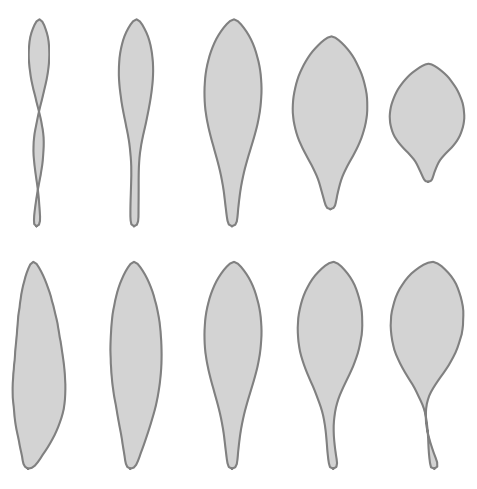

In [14]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 3 PCs ###
###################################################

# calculate standard deviations for each PC
PC1_std = mdata["PC1"].std()
PC2_std = mdata["PC2"].std()

# create list of lists of PC values to reconstruct
PC_vals = [[-2*PC1_std,0],
           [-1*PC1_std,0],
           [0*PC1_std,0],
           [1*PC1_std,0],
           [2*PC1_std,0],
           [0,-2*PC2_std],
           [0,-1*PC2_std],
           [0,0*PC2_std],
           [0,1*PC2_std],
           [0,2*PC2_std],
]

plt.figure(figsize=(5,5))

counter = 1

for i in range(len(PC_vals)):
    
    # create inverse leaf
    inv_leaf = pca.inverse_transform(np.array(PC_vals[i]))
    inv_x = inv_leaf[0::2] # select just inverse x vals
    inv_y = inv_leaf[1::2] # select just inverse y vals
    
    # plot inverse leaf
    plt.subplot(2,5,counter)
    plt.fill(inv_x, inv_y, c="lightgray")
    plt.plot(inv_x, inv_y, c="gray")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    counter += 1

plt.tight_layout()

# Morphospace and Linear Discriminant Analysis by genotype

Visualize a morphospace and classify leaves by the factor of genotype

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Visualize LDA results as a confusion matrix
- Plot out LDA scores
- Note: the number of LDs is 1 minus the number of factor levels. In this example there are two genotypes, so there is only 1 LD
- Note: the column names to plot the Linear Discriminants are manually renamed

Text(0.5, 1.0, 'Procrustean morphospace')

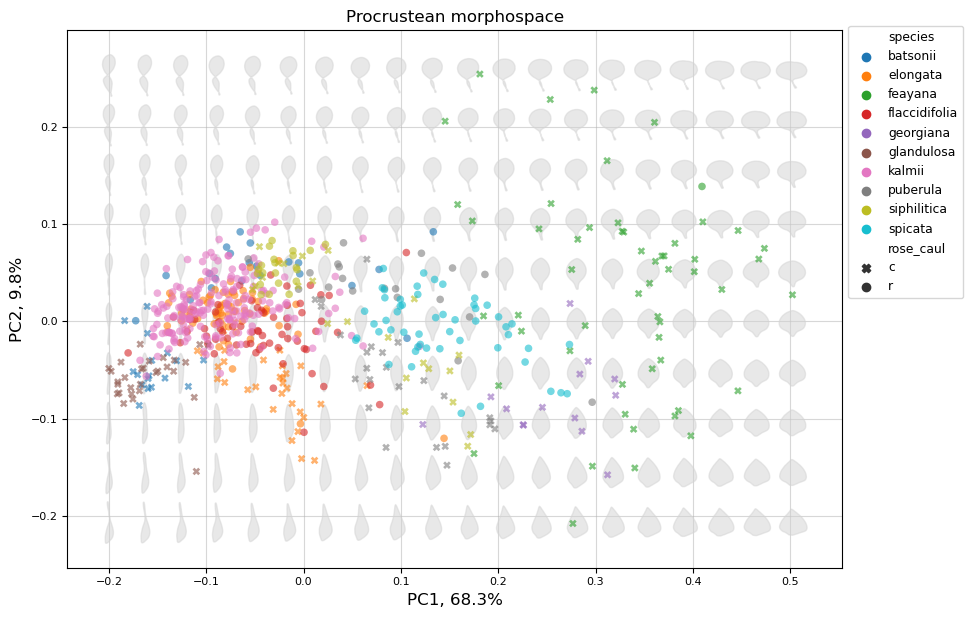

In [15]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 20 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals
hue = "species" # select the factor to color by
style="rose_caul" # select factor for marker style
s = 0.125 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 30 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, style=style, markers=['X', 'o'], s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title)

Text(0.5, 1.0, 'Procrustean morphospace')

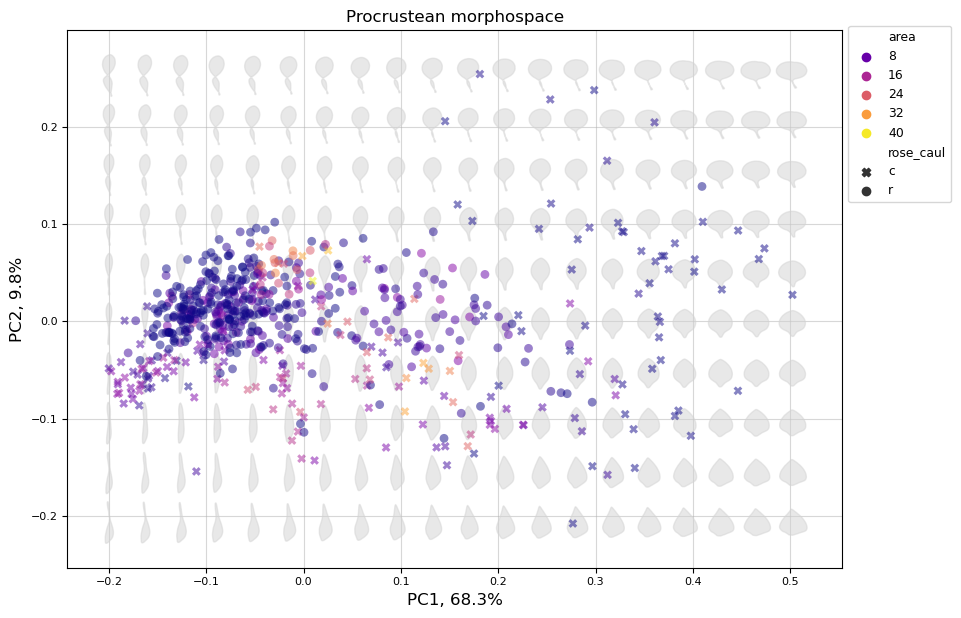

In [16]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 20 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals
hue = "area" # select the factor to color by
style="rose_caul" # select factor for marker style
s = 0.125 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 40 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.5 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, style=style, markers=['X', 'o'],
                s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, palette="plasma")

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 28
The number of correctly predicted: 609
Out of 637 total samples


Text(98.22222222222221, 0.5, 'Actual class')

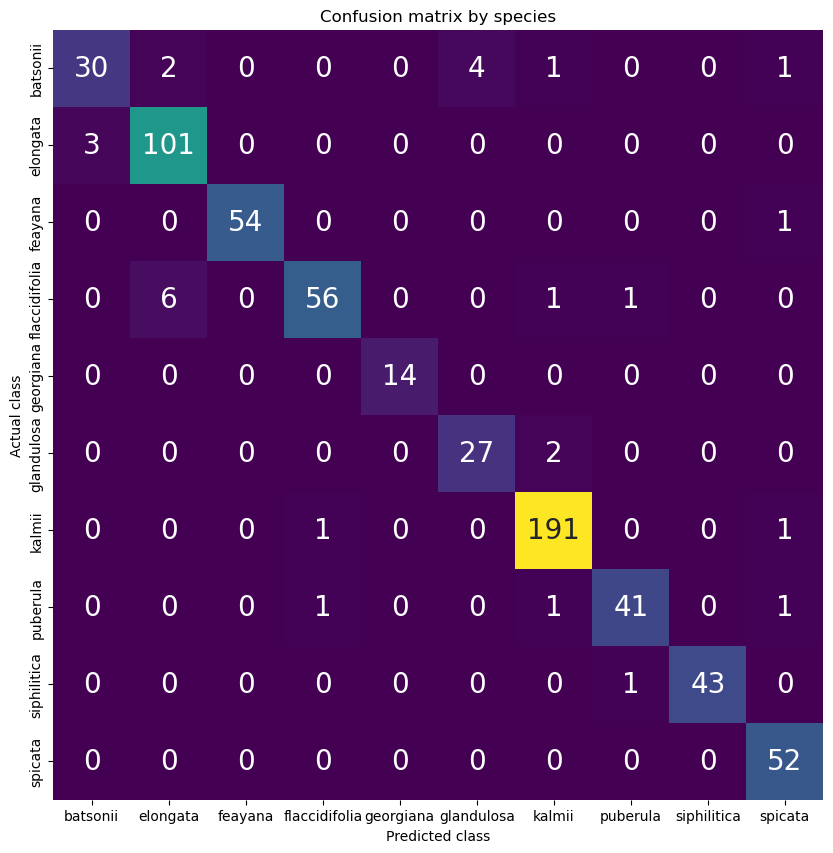

In [17]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by species
species_df = pd.DataFrame(data=flat_arr[:,:])

# add the species labels
species_df["species"] = mdata["species"]

# create input and output variables
X = species_df.iloc[:,0:((res*2)-1)*2]
y = species_df["species"]

# fit the LDA model
species_model = LinearDiscriminantAnalysis()
species_model.fit(X,y)

# retrieve LDA scalings and coefficients
species_scalings = species_model.scalings_
species_coefs = species_model.coef_

# perform prediction
species_prediction = species_model.predict(X)
comparison_result = [X == y for X, y in zip(y, species_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_species_values = mdata["species"]
predicted_species_values = species_prediction

cm_species = confusion_matrix(true_species_values, predicted_species_values)

classes = np.sort(mdata["species"].unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm_species, 
            annot=True, 
            annot_kws={"fontsize":20}, 
            fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by species")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")



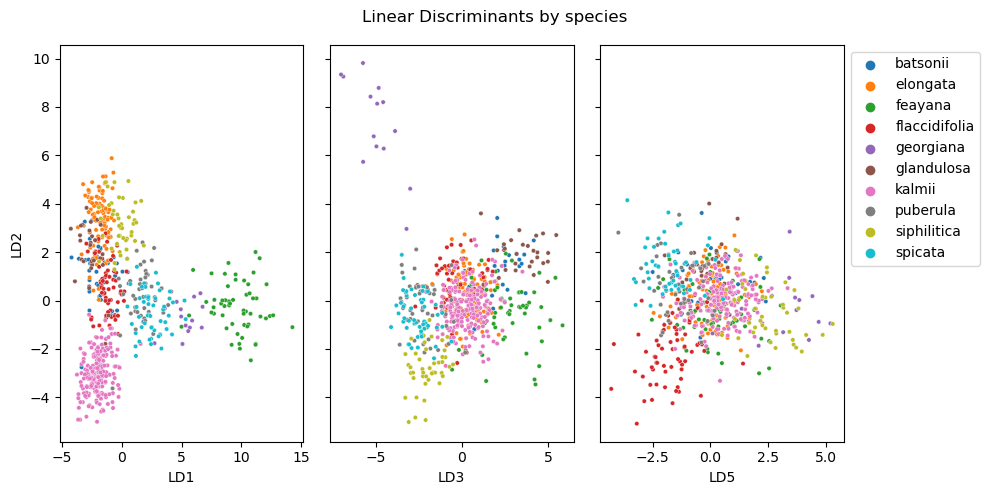

In [18]:
# Plot of linear discriminant scores by genotype

data_plot = species_model.fit(X, y).transform(X)
species_plot_df = pd.DataFrame(data=data_plot[:,:])
species_plot_df["species"] = mdata["species"]

species_plot_df = species_plot_df.rename(columns={0:'LD1', 1:'LD2', 2:"LD3", 3:"LD4", 4:"LD5", 5:"LD6"})

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(10,5))

sns.scatterplot(data=species_plot_df, x="LD1", y="LD2", hue="species", s=10, ax=ax1)
ax1.get_legend().remove()
sns.scatterplot(data=species_plot_df, x="LD3", y="LD4", hue="species", s=10, ax=ax2)
ax2.get_legend().remove()
sns.scatterplot(data=species_plot_df, x="LD5", y="LD6", hue="species", s=10, ax=ax3)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.suptitle("Linear Discriminants by species")

plt.tight_layout()


The number of falsely predicted: 30
The number of correctly predicted: 607
Out of 637 total samples


Text(0.5, 1.0, 'LD1 by rosette/cauline')

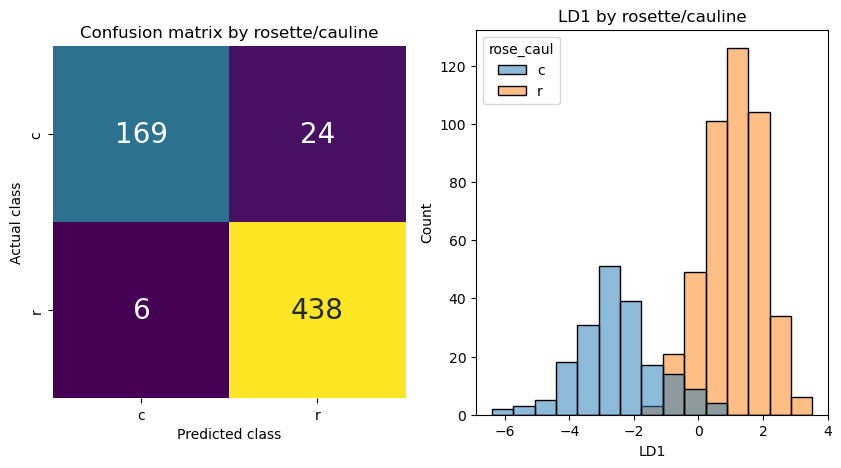

In [19]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by species
rose_df = pd.DataFrame(data=flat_arr[:,:])

# add the species labels
rose_df["rose"] = mdata["rose_caul"]

# create input and output variables
X = rose_df.iloc[:,0:((res*2)-1)*2]
y = rose_df["rose"]

# fit the LDA model
rose_model = LinearDiscriminantAnalysis()
rose_model.fit(X,y)

# retrieve LDA scalings and coefficients
rose_scalings = rose_model.scalings_
rose_coefs = rose_model.coef_

# perform prediction
rose_prediction = rose_model.predict(X)
comparison_result = [X == y for X, y in zip(y, rose_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_rose_values = mdata["rose_caul"]
predicted_rose_values = rose_prediction

cm_rose = confusion_matrix(true_rose_values, predicted_rose_values)

classes = np.sort(mdata["rose_caul"].unique())

# create dataframe for histogram of rosette/cauline LDA

data_plot = rose_model.fit(X, y).transform(X)
rose_plot_df = pd.DataFrame(data=data_plot[:,:])
rose_plot_df["rose_caul"] = mdata["rose_caul"]

rose_plot_df = rose_plot_df.rename(columns={0:'LD1'})

# Confusion matrix

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.heatmap(cm_rose, 
            annot=True, 
            annot_kws={"fontsize":20}, 
            fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by rosette/cauline")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

plt.subplot(1,2,2)
sns.histplot(data=rose_plot_df, x="LD1", hue="rose_caul")
plt.title("LD1 by rosette/cauline")
